# NHANES project about Periodontal disease: descriptive and regression analysis
> This notebook has the purpose to collect all the analysis on Nhanes dataset for a medical paper project 

Requirements and Information:
1. Nhanes dataset from 2009/10 to 2013/14
2. 5 Intrinsic Capacity domains
    1. Locomotion:
        - Standingup from armless chair difficulty (PFQ061I)
    2. Cognitive Function:
        - Trouble concentrating on things (DPQ070)
    3. Vitality:
        - Weight change intentional (WHQ060)
        - Poor appetite or overeating (DPQ050)
    4. Psychological status:
        - Feeling down, depressed, or hopeless (DPQ020)
        - Have little interest in doing things (DPQ010)
    5. Sensory domain:
        - Have serious difficulty hearing? (DLQ010)
        - Have serious difficulty seeing? (DLQ020)
3. Outcome:
    - calculated using Periodontal Exam (OHXPER_H) and CDC/AAP criteria (Eke et al., 2012)
    - consists of 3 categories: None/Mild, Moderate, Severe
4. Confounding Variables:
    - Gender (RIAGENDR)
    - Age at screening (RIDAGEYR)
    - Race (RIDRETH1)
    - Education	(DMDEDUC2)
    - Poverty income ratio (INDFMPIR)
    - Smoking status (SMQ020)
5. Mediators:
    - Heart failure	(RIDRETH1)  
    - Coronary heart disease (MCQ160b)
    - Stroke (MCQ160c)
    - Liver disease	(MCQ160o)
    - Cancer (MCQ500)
    - Diabetes (MCQ220)
    - High blood pressure (DIQ010)
6. Age => 60

## NHANES 2013/14: Intrinsic Capacity and Periodontal disease

### Import Libraries

In [ ]:
library(haven)
library(nhanesA)
library(survey)
library(MASS)
library(dplyr)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(readr)
library(flextable)
library(officer)
library(nnet)
library(broom)

### Configurations

In [2]:
path_to_data <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2013_14/"

path_to_data_09_10 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2009_10/"
path_to_data_11_12 <- "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/2011_12/"

### Load Dataset & Feature Selection

In [4]:
# Datasets for 2009/10 period

demo_09_10 <- read_xpt(file.path(path_to_data_09_10, "DEMO_F.xpt"))

demo_09_10_selected <- demo_09_10 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_09_10 <- read_xpt(file.path(path_to_data_09_10, "ALQ_F.xpt"))

alcohol_09_10_selected <- alcohol_09_10 %>%
  select(SEQN, ALQ101)

smoking_09_10 <- read_xpt(file.path(path_to_data_09_10, "SMQ_F.xpt.txt"))

smoking_09_10_selected <- smoking_09_10 %>%
    select(SEQN, SMQ020)

med_conditions_09_10 <- read_xpt(file.path(path_to_data_09_10, "MCQ_F.xpt"))

med_conditions_09_10_selected <- med_conditions_09_10 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_09_10_selected <- med_conditions_09_10_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_09_10 <- read_xpt(file.path(path_to_data_09_10, "BPQ_F.xpt"))

blood_pressure_09_10_selected <- blood_pressure_09_10 %>%
    select(SEQN, BPQ020)


diabetes_09_10 <- read_xpt(file.path(path_to_data_09_10, "DIQ_F.xpt"))

diabetes_09_10_selected <- diabetes_09_10 %>%
    select(SEQN, DIQ010)


periodontal_09_10 <- read_xpt(file.path(path_to_data_09_10, "OHXPER_F.xpt.txt"))

selected_cols <- colnames(periodontal_09_10)[grepl("^OHX\\d{2}(PC|LA)[A-Z]$", colnames(periodontal_09_10))]

periodontal_09_10_selected <- periodontal_09_10 %>%
    select(SEQN, all_of(selected_cols))


locomotion_09_10 <- read_xpt(file.path(path_to_data_09_10, "PFQ_F.xpt"))

locomotion_09_10_selected <- locomotion_09_10 %>%
    select(SEQN, PFQ061I)


mental_health_09_10 <- read_xpt(file.path(path_to_data_09_10, "DPQ_F.xpt"))

mental_health_09_10_selected <- mental_health_09_10 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_09_10_selected <- mental_health_09_10_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_09_10 <- read_xpt(file.path(path_to_data_09_10, "WHQ_F.xpt"))

weight_history_09_10_selected <- weight_history_09_10 %>%
    select(SEQN, WHQ060)


audiometry_09_10 <- read_xpt(file.path(path_to_data_09_10, "AUQ_F.xpt"))

audiometry_09_10_selected <- audiometry_09_10 %>%
    select(SEQN, AUQ131)

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  mutate(AUQ131 = case_when(
    AUQ131 %in% c(1, 2, 3) ~ 2,
    AUQ131 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ131
  ))

audiometry_09_10_selected <- audiometry_09_10_selected %>%
  rename(DLQ010 = AUQ131)

In [5]:
# Datasets for 2011/12 period

demo_11_12 <- read_xpt(file.path(path_to_data_11_12, "DEMO_G.xpt.txt"))

demo_11_12_selected <- demo_11_12 %>%
  select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)

alcohol_11_12 <- read_xpt(file.path(path_to_data_11_12, "ALQ_G.xpt.txt"))

alcohol_11_12_selected <- alcohol_11_12 %>%
  select(SEQN, ALQ101)


smoking_11_12 <- read_xpt(file.path(path_to_data_11_12, "SMQ_G.xpt.txt"))

smoking_11_12_selected <- smoking_11_12 %>%
    select(SEQN, SMQ020)


med_conditions_11_12 <- read_xpt(file.path(path_to_data_11_12, "MCQ_G.xpt.txt"))

med_conditions_11_12_selected <- med_conditions_11_12 %>%
    select(SEQN, MCQ140, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)

med_conditions_11_12_selected <- med_conditions_11_12_selected %>%
  rename(DLQ020 = MCQ140)


blood_pressure_11_12 <- read_xpt(file.path(path_to_data_11_12, "BPQ_G.xpt.txt"))

blood_pressure_11_12_selected <- blood_pressure_11_12 %>%
    select(SEQN, BPQ020)


diabetes_11_12 <- read_xpt(file.path(path_to_data_11_12, "DIQ_G.xpt.txt"))

diabetes_11_12_selected <- diabetes_11_12 %>%
    select(SEQN, DIQ010)


periodontal_11_12 <- read_xpt(file.path(path_to_data_11_12, "OHXPER_G.xpt.txt"))

selected_cols <- colnames(periodontal_11_12)[grepl("^OHX\\d{2}(PC|LA)[A-Z]$", colnames(periodontal_11_12))]

periodontal_11_12_selected <- periodontal_11_12 %>%
    select(SEQN, all_of(selected_cols))


locomotion_11_12 <- read_xpt(file.path(path_to_data_11_12, "PFQ_G.xpt.txt"))

locomotion_11_12_selected <- locomotion_11_12 %>%
    select(SEQN, PFQ061I)


mental_health_11_12 <- read_xpt(file.path(path_to_data_11_12, "DPQ_G.xpt.txt"))

mental_health_11_12_selected <- mental_health_11_12 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050, DPQ070)

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  mutate(DPQ070 = case_when(
    DPQ070 %in% c(0, 1) ~ 2,
    DPQ070 %in% c(2, 3) ~ 1,
    TRUE ~ DPQ070
  ))

mental_health_11_12_selected <- mental_health_11_12_selected %>%
  rename(DLQ040 = DPQ070)


weight_history_11_12 <- read_xpt(file.path(path_to_data_11_12, "WHQ_G.xpt.txt"))

weight_history_11_12_selected <- weight_history_11_12 %>%
    select(SEQN, WHQ060)


audiometry_11_12 <- read_xpt(file.path(path_to_data_11_12, "AUQ_G.xpt.txt"))

audiometry_11_12_selected <- audiometry_11_12 %>%
  select(SEQN, AUQ054)

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  mutate(AUQ054 = case_when(
    AUQ054 %in% c(1, 2, 3) ~ 2,
    AUQ054 %in% c(4, 5, 6) ~ 1,
    TRUE ~ AUQ054
  ))

audiometry_11_12_selected <- audiometry_11_12_selected %>%
  rename(DLQ010 = AUQ054)

In [6]:
# Datasets for 2013/14 period

demo_13_14 <- read_xpt(file.path(path_to_data, "DEMO_H.xpt.txt"))

demo_13_14_selected <- demo_13_14 %>%
    select(SEQN, RIAGENDR, RIDAGEYR, RIDRETH1, DMDEDUC2, INDFMPIR)


alcohol_13_14 <- read_xpt(file.path(path_to_data, "ALQ_H.xpt.txt"))

alcohol_13_14_selected <- alcohol_13_14 %>%
    select(SEQN, ALQ101)


smoking_13_14 <- read_xpt(file.path(path_to_data, "SMQ_H.xpt.txt"))

smoking_13_14_selected <- smoking_13_14 %>%
    select(SEQN, SMQ020)


med_conditions_13_14 <- read_xpt(file.path(path_to_data, "MCQ_H.xpt.txt"))

med_conditions_13_14_selected <- med_conditions_13_14 %>%
    select(SEQN, MCQ160B, MCQ160C, MCQ160D, MCQ160E, MCQ160F, MCQ160L, MCQ220)


blood_pressure_13_14 <- read_xpt(file.path(path_to_data, "BPQ_H.xpt.txt"))

blood_pressure_13_14_selected <- blood_pressure_13_14 %>%
    select(SEQN, BPQ020)


diabetes_13_14 <- read_xpt(file.path(path_to_data, "DIQ_H.xpt.txt"))

diabetes_13_14_selected <- diabetes_13_14 %>%
    select(SEQN, DIQ010)


periodontal_13_14 <- read_xpt(file.path(path_to_data, "OHXPER_H.xpt.txt"))

selected_cols <- colnames(periodontal_13_14)[grepl("^OHX\\d{2}(PC|LA)[A-Z]$", colnames(periodontal_13_14))]

periodontal_13_14_selected <- periodontal_13_14 %>%
    select(SEQN, all_of(selected_cols))


locomotion_13_14 <- read_xpt(file.path(path_to_data, "PFQ061I.txt"))

locomotion_13_14_selected <- locomotion_13_14 %>%
    select(SEQN, PFQ061I)


disability_13_14 <- read_xpt(file.path(path_to_data, "DLQ040.txt"))

disability_13_14_selected <- disability_13_14 %>%
    select(SEQN, DLQ010, DLQ020, DLQ040)


mental_health_13_14 <- read_xpt(file.path(path_to_data, "DPQ-.txt"))

mental_health_13_14_selected <- mental_health_13_14 %>%
    select(SEQN, DPQ010, DPQ020, DPQ050)


weight_history_13_14 <- read_xpt(file.path(path_to_data, "WHQ060.txt"))

weight_history_13_14_selected <- weight_history_13_14 %>%
    select(SEQN, WHQ060)

In [7]:
dim(periodontal_09_10_selected)
dim(periodontal_11_12_selected)
dim(periodontal_13_14_selected)

[1] 5037  337

[1] 4365  337

[1] 4669  337

### Merge datasets without NA and missing values

In [8]:
# Vertical union for periodontal data: removing patients with 0 teeth 

df_periodontal <- bind_rows(periodontal_09_10_selected, periodontal_11_12_selected, periodontal_13_14_selected)

df_periodontal_clean <- df_periodontal[rowSums(df_periodontal[, colnames(df_periodontal) != "SEQN"] == 99) != (ncol(df_periodontal) - 1), ]

print(paste("Deleted Rows:", nrow(df_periodontal) - nrow(df_periodontal_clean)))

dim(df_periodontal_clean)

[1] "Deleted Rows: 1071"


[1] 13000   337

In [9]:
# Merge datasets demographics and intrinsic capacity data

datasets_09_10 <- list(
  demo_09_10_selected, alcohol_09_10_selected, smoking_09_10_selected, med_conditions_09_10_selected,
  blood_pressure_09_10_selected, diabetes_09_10_selected,
  locomotion_09_10_selected, mental_health_09_10_selected,
  weight_history_09_10_selected, audiometry_09_10_selected
)

datasets_11_12 <- list(
  demo_11_12_selected, alcohol_11_12_selected, smoking_11_12_selected, med_conditions_11_12_selected,
  blood_pressure_11_12_selected, diabetes_11_12_selected,
  locomotion_11_12_selected, mental_health_11_12_selected,
  weight_history_11_12_selected, audiometry_11_12_selected
)

datasets_13_14 <- list(
  demo_13_14_selected, alcohol_13_14_selected, smoking_13_14_selected, med_conditions_13_14_selected,
  blood_pressure_13_14_selected, diabetes_13_14_selected,
  locomotion_13_14_selected, disability_13_14_selected, mental_health_13_14_selected,
  weight_history_13_14_selected
)

# Horizontal union for period 2009/10, 2011/12, 2013/14

df_09_10 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_09_10)

df_11_12 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_11_12)

df_13_14 <- Reduce(function(x, y) full_join(x, y, by = "SEQN"), datasets_13_14)

# Vertical union

df_final <- bind_rows(df_09_10, df_11_12, df_13_14)

print("Dimensions before removing NA values")
dim(df_final)

# Remove NA values

df_final <- na.omit(df_final)

df_final <- df_final %>%
  filter(!if_any(c(DMDEDUC2, ALQ101, DLQ020, MCQ160B, MCQ160C, MCQ160D, 
                   MCQ160E, MCQ160F, MCQ160L, BPQ020, DIQ010, PFQ061I, 
                   DPQ020, DPQ050, DPQ010), ~ . == 9))

df_final <- df_final %>%
  filter(!if_any(c(DPQ010), ~ . == 7))

df_final <- df_final %>%
  filter(!if_any(c(DLQ010), ~ . == 99))

print("Dimensions after removing NA values")
dim(df_final)

# Filter with AGE >= 60

df_final_age_60 <- subset(df_final, RIDAGEYR >= 60)

print("Dimensions with AGE >= 60")
dim(df_final_age_60)

[1] "Dimensions before removing NA values"


[1] 30468    25

[1] "Dimensions after removing NA values"


[1] 1352   25

[1] "Dimensions with AGE >= 60"


[1] 890  25

In [10]:
# Merge df_final_age_60 with features for periodontal disease

df_final_merged <- df_final_age_60 %>%
  inner_join(df_periodontal_clean, by = "SEQN")

dim(df_final_merged)

[1] 551 361

In [11]:
# Saving completed and cleaned dataframe for analysis

write.csv(df_final_merged, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/merged_and_cleaned_df_09_14.csv")

### Periodontitis Classification

In [12]:
classify_periodontitis <- function(df) {
  # Function to count sites on different teeth that meet a criterion
  count_sites_different_teeth <- function(tooth_sites,
                                          threshold, measurement_type) {
    teeth_with_sites <- list()
    for(tooth in unique(sub("(OHX\\d+).*", "\\1", names(tooth_sites)))) {
      # Include all interproximal sites
      # S = mesio-facial, D = distal, A = mesio-lingual, P = disto-lingual
      tooth_cols <- grep(paste0(tooth, measurement_type, "[SDAP]$"), 
                        names(tooth_sites), value = TRUE)
      values <- as.numeric(tooth_sites[tooth_cols])
      valid_values <- values[values != 99 & !is.na(values)]
      # If at least one site exceeds the threshold, add to list
      if(length(valid_values) > 0 && any(valid_values >= threshold)) {
        teeth_with_sites <- c(teeth_with_sites, tooth)
      }
    }
    # Returns the number of different teeth with sites exceeding the threshold
    return(length(teeth_with_sites))
  }

  ppd_cols <- grep("PC[SDAP]$", names(df), value = TRUE)
  cal_cols <- grep("LA[SDAP]$", names(df), value = TRUE)

  # Initializes the columns for classification
  df$severe <- FALSE
  df$moderate <- FALSE
  df$mild <- FALSE

  for(i in 1:nrow(df)) {
    ppd_values <- df[i, ppd_cols]
    cal_values <- df[i, cal_cols]

    # Counts teeth with sites that meet the criteria
    teeth_with_cal_6mm <- count_sites_different_teeth(cal_values, 6, "LA")
    teeth_with_cal_4mm <- count_sites_different_teeth(cal_values, 4, "LA")
    teeth_with_cal_3mm <- count_sites_different_teeth(cal_values, 3, "LA")
    teeth_with_ppd_5mm <- count_sites_different_teeth(ppd_values, 5, "PC")
    teeth_with_ppd_4mm <- count_sites_different_teeth(ppd_values, 4, "PC")

    # Severe periodontitis classification
    # ≥2 teeth with interproximal sites CAL ≥6 mm AND ≥1 tooth with PPD ≥5 mm
    if(teeth_with_cal_6mm >= 2 && teeth_with_ppd_5mm >= 1) {
      df$severe[i] <- TRUE
    }
    # Moderate periodontitis classification
    # ≥2 teeth with interproximal sites CAL ≥4 mm OR ≥2 tooth with PPD ≥5 mm
    else if(teeth_with_cal_4mm >= 2 || teeth_with_ppd_5mm >= 2) {
      df$moderate[i] <- TRUE
    }
    # Mild periodontitis
    # ≥2 teeth with interproximal sites CAL ≥3 mm AND
    # ≥2 teeth with interproximal sites PPD ≥4 mm
    else if(teeth_with_cal_3mm >= 2 &&
              teeth_with_ppd_4mm >= 2) {
      df$mild[i] <- TRUE
    }
  }

  # Final Classification
  df$periodontitis <- case_when(
    df$severe ~ "Severe",
    df$moderate ~ "Moderate",
    #TRUE ~ "None/Mild"
    df$mild ~ "Mild",
    TRUE ~ "None"
  )

  return(df)
}

In [13]:
df_classification <- classify_periodontitis(df_final_merged)

In [14]:
table_counts <- table(df_classification$periodontitis)
table_percent <- prop.table(table_counts) * 100

print("Distribution of periodontitis categories (counting):")
print(table_counts)

print("Distribution of periodontitis categories (percentage):")
print(round(table_percent, 2))

[1] "Distribution of periodontitis categories (counting):"



    Mild Moderate     None   Severe 
      11      286      171       83 
[1] "Distribution of periodontitis categories (percentage):"

    Mild Moderate     None   Severe 
    2.00    51.91    31.03    15.06 


### Calculate Mean PPD and Mean CAL

In [15]:
calculate_means <- function(df) {
  # Select columns for interproximal sites
  ppd_cols <- grep("PC[SDAP]$", names(df), value = TRUE)
  cal_cols <- grep("LA[SDAP]$", names(df), value = TRUE)
  
  # Calculate the average excluding invalid values
  calculate_valid_mean <- function(row, cols) {
    values <- as.numeric(row[cols])
    valid_values <- values[values != 99 & !is.na(values)]
    if(length(valid_values) > 0) {
      return(mean(valid_values, na.rm = TRUE))
    } else {
      return(NA)
    }
  }
  
  df$mean_ppd <- apply(df[ppd_cols], 1, calculate_valid_mean, cols = ppd_cols)
  df$mean_cal <- apply(df[cal_cols], 1, calculate_valid_mean, cols = cal_cols)
  
  df$mean_ppd <- round(df$mean_ppd, 2)
  df$mean_cal <- round(df$mean_cal, 2)
  
  return(df)
}

In [16]:
df_class_with_means <- calculate_means(df_classification)

dim(df_class_with_means)
head(df_class_with_means)

[1] 551 367

SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,ALQ101,SMQ020,DLQ020,MCQ160B,...,OHX31LAS,OHX31LAP,OHX31LAL,OHX31LAA,severe,moderate,mild,periodontitis,mean_ppd,mean_cal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>,<dbl>
51633,1,80,3,4,1.27,1,1,1,2,...,99,99,99,99,FALSE,TRUE,FALSE,Moderate,2.26,1.26
51654,1,66,3,4,2.20,1,1,2,2,...,99,99,99,99,FALSE,TRUE,FALSE,Moderate,1.95,1.72
51680,2,60,4,4,2.59,1,1,1,2,...,99,99,99,99,TRUE,FALSE,FALSE,Severe,1.81,1.48
51687,1,78,3,5,5.00,1,1,2,2,...,1,1,1,1,FALSE,FALSE,FALSE,None,1.29,1.27
51736,2,60,1,3,0.68,1,1,2,2,...,99,99,99,99,FALSE,TRUE,FALSE,Moderate,2.49,1.99
51861,1,80,3,3,4.94,1,2,2,2,...,99,99,99,99,FALSE,TRUE,FALSE,Moderate,1.70,1.33


### Features selection

In [17]:
# Features selection for the descriptive and regression analysis

columns_to_keep <- c("SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH1",
                     "DMDEDUC2", "INDFMPIR",
                     "SMQ020", "ALQ101", "MCQ160B", "MCQ160C",
                     "MCQ160D", "MCQ160E", "MCQ160F",
                     "MCQ160L", "MCQ220", "BPQ020",
                     "DIQ010", "PFQ061I",
                     "DLQ010", "DLQ020", "DLQ040",
                     "DPQ010", "DPQ020", "DPQ050", "WHQ060",
                     "periodontitis", "mean_ppd", "mean_cal")

df <- df_class_with_means[, columns_to_keep]

dim(df)
head(df)

[1] 551  28

SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,SMQ020,ALQ101,MCQ160B,MCQ160C,...,DLQ010,DLQ020,DLQ040,DPQ010,DPQ020,DPQ050,WHQ060,periodontitis,mean_ppd,mean_cal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
51633,1,80,3,4,1.27,1,1,2,2,...,2,1,2,0,0,0,1,Moderate,2.26,1.26
51654,1,66,3,4,2.20,1,1,2,2,...,2,2,2,0,0,0,2,Moderate,1.95,1.72
51680,2,60,4,4,2.59,1,1,2,2,...,2,1,2,0,1,1,1,Severe,1.81,1.48
51687,1,78,3,5,5.00,1,1,2,2,...,2,2,2,0,0,0,2,None,1.29,1.27
51736,2,60,1,3,0.68,1,1,2,2,...,2,2,2,0,1,0,1,Moderate,2.49,1.99
51861,1,80,3,3,4.94,2,1,2,1,...,1,2,2,0,0,0,1,Moderate,1.70,1.33


In [19]:
write.csv(df, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/preprocessed_df_09_14.csv")

### Descriptive analysis

In [91]:
# Function for the descriptive analysis

create_descriptive_table <- function(df) {
  require(tableone)
  require(dplyr)

  df$periodontitis <- factor(df$periodontitis, levels = c("None", "Mild", "Moderate", "Severe"))
  
  # Recoding categorical variables
  df <- df %>%
    mutate(
      `Age (years)` = RIDAGEYR,
      `Ratio of family income` = INDFMPIR,
      `Mean PPD` = mean_ppd,
      `Mean CAL` = mean_cal,
      Gender = factor(RIAGENDR, levels = c(1, 2), 
                      labels = c("Male", "Female")),
      
      Ethnicity = factor(RIDRETH1, levels = 1:5, 
                         labels = c("Mexican American", "Other Hispanic",
                                    "Non-Hispanic White", "Non-Hispanic Black",
                                    "Other Race")),
      
      Education = factor(DMDEDUC2, levels = 1:5,
                         labels = c("Less than 9th grade", "9-11th grade",
                                    "High school graduate",
                                    "Some college/AA degree",
                                    "College graduate or above")),
      
      Smoking = factor(SMQ020, levels = c(1, 2),
                       labels = c("Yes", "No")),
      
      `Alcohol intake` = factor(ALQ101, levels = c(1, 2),
                       labels = c("Over 12 alcohol drinks/1 yr",
                       "Under 12 alcohol drinks/1 yr")),
      
      `Heart Failure` = factor(MCQ160B, levels = c(1, 2), 
                             labels = c("Yes", "No")),
      `Coronary Heart` = factor(MCQ160C, levels = c(1, 2),
                              labels = c("Yes", "No")),
      Angina = factor(MCQ160D, levels = c(1, 2),
                      labels = c("Yes", "No")),
      `Heart Attack` = factor(MCQ160E, levels = c(1, 2),
                            labels = c("Yes", "No")),
      Stroke = factor(MCQ160F, levels = c(1, 2),
                      labels = c("Yes", "No")),
      Cancer = factor(MCQ220, levels = c(1, 2),
                    labels = c("Yes", "No")),
      Liver = factor(MCQ160L, levels = c(1, 2),
                     labels = c("Yes", "No")),
      Hypertension = factor(BPQ020, levels = c(1,2),
                            labels = c("Yes", "No")),
      Diabetes = factor(DIQ010, levels = 1:3,
                        labels = c("Yes", "No", "Borderline"))
    )
  
  continuous_vars <- c("Age (years)", "Ratio of family income", "Mean PPD", "Mean CAL")
  
  categorical_vars <- c("Gender", "Ethnicity", "Education", "Smoking", "Alcohol intake",
                        "Heart Failure", "Coronary Heart", "Angina", "Heart Attack",
                        "Stroke", "Cancer", "Liver", "Hypertension", "Diabetes")

  table1 <- CreateTableOne(vars = c(continuous_vars, categorical_vars),
                           strata = "periodontitis",
                           data = df,
                           test = TRUE)

  cont_vars_overall <- c("Age (years)", "Ratio of family income")
  
  table_overall <- CreateTableOne(vars = c(cont_vars_overall, categorical_vars),
                                  data = df,
                                  test = FALSE)
  
  formatted_table <- print(table1,
                           #nonnormal = continuous_vars,
                           nonnormal = NULL,
                           contDigits = 2,
                           showAllLevels = TRUE,
                           printToggle = FALSE,
                           smd = FALSE)
  
  formatted_table_overall <- print(table_overall,
                                   #nonnormal = continuous_vars,
                                   nonnormal = NULL,
                                   contDigits = 2,
                                   showAllLevels = TRUE,
                                   printToggle = FALSE,
                                   smd = FALSE)
  
  final_table <- list("Stratified by periodontitis" = formatted_table, 
                      "Overall" = formatted_table_overall)
  
  return(final_table)
}

In [94]:
descriptive_table <- create_descriptive_table(df)

descriptive_table

,level,None,Mild,Moderate,Severe,p,test
n,,171,11,286,83,,
Age (years) (mean (SD)),,67.56 (6.50),67.27 (6.63),69.40 (6.85),67.76 (6.75),0.021,
Ratio of family income (mean (SD)),,3.18 (1.61),2.84 (1.41),2.50 (1.54),1.97 (1.41),<0.001,
Mean PPD (mean (SD)),,1.33 (0.39),1.97 (0.35),1.81 (0.47),2.85 (0.99),<0.001,
Mean CAL (mean (SD)),,1.33 (0.60),1.29 (0.20),2.50 (1.09),4.29 (2.03),<0.001,
Gender (%),Male,72 (42.1),6 ( 54.5),154 (53.8),60 (72.3),<0.001,
,Female,99 (57.9),5 ( 45.5),132 (46.2),23 (27.7),,
Ethnicity (%),Mexican American,10 ( 5.8),1 ( 9.1),28 ( 9.8),20 (24.1),<0.001,
,Other Hispanic,19 (11.1),1 ( 9.1),23 ( 8.0),4 ( 4.8),,
,Non-Hispanic White,97 (56.7),6 ( 54.5),127 (44.4),23 (27.7),,


In [95]:
# Save tables as csv files

write.csv(descriptive_table$`Stratified by periodontitis`,
          "descriptive_table_stratified.csv", row.names = TRUE)

write.csv(descriptive_table$Overall,
          "descriptive_table_overall.csv", row.names = TRUE)

### Regression Analysis

In [69]:
# Load preprocessed and cleaned df

df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/preprocessed_df_09_14.csv",
               header = TRUE)

head(df)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,SMQ020,ALQ101,MCQ160B,MCQ160C,...,DLQ010,DLQ020,DLQ040,DPQ010,DPQ020,DPQ050,WHQ060,periodontitis,mean_ppd,mean_cal
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,51633,1,80,3,4,1.27,1,1,2,2,...,2,1,2,0,0,0,1,Moderate,2.26,1.26
2,51654,1,66,3,4,2.20,1,1,2,2,...,2,2,2,0,0,0,2,Moderate,1.95,1.72
3,51680,2,60,4,4,2.59,1,1,2,2,...,2,1,2,0,1,1,1,Severe,1.81,1.48
4,51687,1,78,3,5,5.00,1,1,2,2,...,2,2,2,0,0,0,2,None,1.29,1.27
5,51736,2,60,1,3,0.68,1,1,2,2,...,2,2,2,0,1,0,1,Moderate,2.49,1.99
6,51861,1,80,3,3,4.94,2,1,2,1,...,1,2,2,0,0,0,1,Moderate,1.70,1.33


In [70]:
# Recoding of the outcome with 3 levels: "None/Mild", "Moderate", "Severe"

df <- df %>%
  mutate(periodontitis = recode(periodontitis,
                                "Mild" = "None/Mild",
                                "None" = "None/Mild"))

df$periodontitis <- factor(df$periodontitis,
                           levels = c("None/Mild", "Moderate", "Severe"),
                           ordered = TRUE)

In [71]:
table(df$periodontitis)


None/Mild  Moderate    Severe 
      182       286        83 

In [72]:
# Create a df copy (just in case)

df_prove <- df

In [73]:
# Recoding binary variables (1/2 -> 0/1): 0 as "No", 1 as "Yes"

binary_vars <- c("DLQ040", "WHQ060", "DLQ010", "DLQ020")
for(var in binary_vars) {
  df_prove[[var]] <- ifelse(df_prove[[var]] == 1, 1, 0)
}

In [74]:
# Recoding multi level variables as binary variable: 0 as "No", 1 as "Yes"

df_prove <- df_prove %>% mutate(
  # Locomotion
  PFQ061I_bin = ifelse(PFQ061I == 1, 0, 1),
  
  # Vitality
  DPQ050_bin = ifelse(DPQ050 == 0, 0, 1),
  
  # Psychological
  DPQ020_bin = ifelse(DPQ020 == 0, 0, 1),
  DPQ010_bin = ifelse(DPQ010 == 0, 0, 1)
)

In [15]:
# Saving recoded df

write.csv(df_prove, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", row.names = FALSE)

In [ ]:
# Function to run a crude logistic regression analysis

run_logistic_analysis <- function(df, predictor) {

  df$moderate = ifelse(df$periodontitis == "Moderate", 1, 0)
  df$severe = ifelse(df$periodontitis == "Severe", 1, 0)
  
  results = list()
  
  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    or <- exp(coef(model)[2])
    ci <- exp(confint(model)[2,])
    p_value <- coef_summary$coefficients[2,4]
    
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }
  
  for(outcome in c("moderate", "severe")) {
    # Overall
    model_overall = glm(as.formula(paste(outcome, "~", predictor)),
                       family = binomial, data = df)
    
    # Males only
    model_males = glm(as.formula(paste(outcome, "~", predictor)),
                     family = binomial, data = df[df$RIAGENDR == 1,])
    
    # Females only
    model_females = glm(as.formula(paste(outcome, "~", predictor)),
                       family = binomial, data = df[df$RIAGENDR == 2,])
    
    results[[outcome]] = list(
      overall = get_model_stats(model_overall),
      males = get_model_stats(model_males),
      females = get_model_stats(model_females)
    )
  }
  
  return(results)
}

In [75]:
# Function to format results in a precise table

format_results <- function(results_list, predictors) {
  formatted_table <- data.frame(
    Predictor = character(),
    `Moderate (Overall)` = character(),
    `Moderate (Males)` = character(),
    `Moderate (Females)` = character(),
    `Severe (Overall)` = character(),
    `Severe (Males)` = character(),
    `Severe (Females)` = character(),
    stringsAsFactors = FALSE
  )
  
  format_stats <- function(stats) {
    stars <- ifelse(stats$p < 0.001, "***",
                   ifelse(stats$p < 0.01, "**",
                          ifelse(stats$p < 0.05, "*", "")))
    
    paste0(
      round(stats$or, 2), " (",
      round(stats$ci_low, 2), "-",
      round(stats$ci_high, 2), ")",
      stars
    )
  }
  
  for(pred in names(results_list)) {
    res <- results_list[[pred]]
    
    row <- data.frame(
      Predictor = pred,
      `Moderate (Overall)` = format_stats(res$moderate$overall),
      `Moderate (Males)` = format_stats(res$moderate$males),
      `Moderate (Females)` = format_stats(res$moderate$females),
      `Severe (Overall)` = format_stats(res$severe$overall),
      `Severe (Males)` = format_stats(res$severe$males),
      `Severe (Females)` = format_stats(res$severe$females)
    )
    
    formatted_table <- rbind(formatted_table, row)
  }
  
  predictor_names <- c(
    "PFQ061I_bin" = "Locomotion",
    "DLQ040" = "Cognitive Function",
    "WHQ060" = "Vitality (Weight changes)",
    "DPQ050_bin" = "Vitality (Appetite)",
    "DPQ020_bin" = "Psychological status (Emotional status)",
    "DPQ010_bin" = "Psychological status (Expressing interest)",
    "DLQ010" = "Sensory (Difficulty hearing)",
    "DLQ020" = "Sensory (Difficulty seeing)"
  )
  
  formatted_table$Predictor <- predictor_names[formatted_table$Predictor]
  
  formatted_table <- formatted_table[match(predictor_names, formatted_table$Predictor), ]
  
  return(formatted_table)
}

In [ ]:
# Perform Crude Logistic Regression

predictors <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin", 
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list <- setNames(
  lapply(predictors, function(pred) run_logistic_analysis(df_prove, pred)),
  predictors
)

final_table <- format_results(results_list, predictors)
final_table

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

W

,Predictor,Moderate..Overall.,Moderate..Males.,Moderate..Females.,Severe..Overall.,Severe..Males.,Severe..Females.
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Locomotion,1.23 (0.84-1.82),1.18 (0.68-2.05),1.3 (0.75-2.26),1.66 (0.99-2.72)*,1.56 (0.81-2.91),2.26 (0.92-5.4)
2,Cognitive Function,1.34 (0.71-2.59),1.25 (0.49-3.32),1.43 (0.6-3.59),0.77 (0.26-1.86),0.71 (0.16-2.22),1.03 (0.16-3.87)
3,Vitality (Weight changes),0.8 (0.57-1.13),1.01 (0.63-1.61),0.62 (0.37-1.03),0.7 (0.44-1.13),0.73 (0.41-1.31),0.69 (0.29-1.69)
4,Vitality (Appetite),0.71 (0.48-1.05),0.92 (0.5-1.69),0.58 (0.34-1)*,1.42 (0.83-2.38),1.41 (0.68-2.81),2.36 (0.98-5.65)
5,Psychological status (Emotional status),0.9 (0.62-1.32),0.91 (0.52-1.6),0.91 (0.54-1.54),1.69 (1.02-2.76)*,1.88 (0.97-3.55),2.17 (0.9-5.19)
6,Psychological status (Expressing interest),0.84 (0.57-1.23),1.19 (0.66-2.14),0.63 (0.37-1.07),0.82 (0.46-1.41),0.79 (0.35-1.61),1.24 (0.48-2.99)
7,Sensory (Difficulty hearing),1.84 (1.13-3.05)*,1.77 (0.97-3.34),1.94 (0.85-4.71),1.13 (0.57-2.1),0.75 (0.33-1.58),2.05 (0.56-6.06)
8,Sensory (Difficulty seeing),1.08 (0.7-1.68),0.96 (0.53-1.76),1.24 (0.66-2.35),1.83 (1.04-3.12)*,1.55 (0.76-3.05),2.69 (1.02-6.66)*


In [ ]:
# Saving Table in the csv format

csv_table <- final_table
colnames(csv_table) <- c(
    "Predictor",
    "Moderate periodontitis - OR (95% CI) - Overall",
    "Moderate periodontitis - OR (95% CI) - Males",
    "Moderate periodontitis - OR (95% CI) - Females",
    "Severe periodontitis - OR (95% CI) - Overall",
    "Severe periodontitis - OR (95% CI) - Males",
    "Severe periodontitis - OR (95% CI) - Females"
)

write.csv(csv_table, "logistic_regression_results.csv", row.names = FALSE)

In [ ]:
# Saving Table in the docx format

library(flextable)

final_table_formatted <- flextable(final_table) %>%
  set_header_labels(
    Predictor = "",
    `Moderate (Overall)` = "Overall",
    `Moderate (Males)` = "Males",
    `Moderate (Females)` = "Females",
    `Severe (Overall)` = "Overall",
    `Severe (Males)` = "Males",
    `Severe (Females)` = "Females"
  ) %>%
  add_header_rows(
    values = c("", "Moderate periodontitis - OR (95% CI)", "Severe periodontitis - OR (95% CI)"),
    colwidths = c(1, 3, 3)
  ) %>%
  italic(j = 2:7) %>%  
  font(fontname = "Times New Roman", part = "all") %>%
  fontsize(size = 10, part = "all") %>%
  align(align = "center", j = 2:7) %>%
  align(align = "left", j = 1)

save_as_docx(final_table_formatted, path = "regression_results.docx")

In [98]:
# Function to run a adjusted logistic regression analysis

run_adjusted_logistic_analysis <- function(df, predictor) {
  df$moderate = ifelse(df$periodontitis == "Moderate", 1, 0)
  df$severe = ifelse(df$periodontitis == "Severe", 1, 0)
  results = list()

  get_model_stats <- function(model) {
    coef_summary <- summary(model)
    pred_idx <- which(rownames(coef_summary$coefficients) == predictor)
    or <- exp(coef(model)[pred_idx])
    ci <- exp(confint(model)[pred_idx,])
    p_value <- coef_summary$coefficients[pred_idx,4]
    return(list(
      or = or,
      ci_low = ci[1],
      ci_high = ci[2],
      p = p_value
    ))
  }

  adjusted_formula <- paste(
    "~ ", predictor, " + RIDAGEYR + RIAGENDR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
  )

  for(outcome in c("moderate", "severe")) {
    # Overall
    model_overall = glm(as.formula(paste(outcome, adjusted_formula)),
                       family = binomial, data = df)

    # Males only (removed RIAGENDR from formula for Gender subgroups)
    males_formula <- paste(
      "~ ", predictor, " + RIDAGEYR + SMQ020 + INDFMPIR + DMDEDUC2 + ALQ101"
    )
    model_males = glm(as.formula(paste(outcome, males_formula)),
                      family = binomial, data = df[df$RIAGENDR == 1,])
    
    # Females only
    model_females = glm(as.formula(paste(outcome, males_formula)),
                        family = binomial, data = df[df$RIAGENDR == 2,])

    results[[outcome]] = list(
      overall = get_model_stats(model_overall),
      males = get_model_stats(model_males),
      females = get_model_stats(model_females)
    )
  }
  
  return(results)
}

In [99]:
# Perform Adjusted Regression

predictors <- c("PFQ061I_bin", "DLQ040", "WHQ060", "DPQ050_bin",
                "DPQ020_bin", "DPQ010_bin", "DLQ010", "DLQ020")

results_list <- setNames(
  lapply(predictors,
         function(pred) run_adjusted_logistic_analysis(df_prove, pred)),
  predictors
)

final_table <- format_results(results_list, predictors)
final_table

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

W

,Predictor,Moderate..Overall.,Moderate..Males.,Moderate..Females.,Severe..Overall.,Severe..Males.,Severe..Females.
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Locomotion,1.06 (0.71-1.6),1.18 (0.67-2.09),0.89 (0.49-1.63),1.45 (0.84-2.47),1.3 (0.66-2.51),1.54 (0.58-4)
2,Cognitive Function,1.15 (0.59-2.27),1.05 (0.4-2.88),1.1 (0.44-2.85),0.69 (0.23-1.73),0.66 (0.14-2.17),0.73 (0.11-2.9)
3,Vitality (Weight changes),0.96 (0.67-1.39),1.04 (0.64-1.7),0.9 (0.51-1.62),0.85 (0.52-1.42),0.84 (0.46-1.54),0.89 (0.34-2.35)
4,Vitality (Appetite),0.71 (0.47-1.07),0.98 (0.52-1.85),0.56 (0.32-0.98)*,1.56 (0.88-2.72),1.21 (0.56-2.5),2.38 (0.94-5.98)
5,Psychological status (Emotional status),0.82 (0.54-1.23),0.93 (0.51-1.69),0.73 (0.4-1.29),1.42 (0.82-2.42),1.35 (0.67-2.63),1.56 (0.6-3.95)
6,Psychological status (Expressing interest),0.79 (0.52-1.19),1.25 (0.68-2.32),0.53 (0.29-0.94)*,0.7 (0.38-1.25),0.59 (0.26-1.25),0.88 (0.32-2.24)
7,Sensory (Difficulty hearing),1.58 (0.95-2.66),1.73 (0.93-3.33),1.35 (0.56-3.39),0.87 (0.43-1.69),0.67 (0.28-1.45),1.85 (0.47-5.97)
8,Sensory (Difficulty seeing),0.95 (0.6-1.49),0.9 (0.48-1.69),0.99 (0.51-1.95),1.56 (0.86-2.76),1.28 (0.61-2.61),2.2 (0.8-5.7)


In [143]:
# Function to prepare data for the forest plot from results_list

prepare_forest_data_from_list <- function(results_list, outcome_type, analysis_type, predictor_names) {
  plot_data <- data.frame(
    predictor = character(),
    predictor_label = character(),
    or = numeric(),
    ci_low = numeric(),
    ci_high = numeric(),
    p_value = numeric(),
    stringsAsFactors = FALSE
  )
  
  for(pred in names(results_list)) {
    if(outcome_type %in% names(results_list[[pred]]) && 
       analysis_type %in% names(results_list[[pred]][[outcome_type]])) {
      
      result <- results_list[[pred]][[outcome_type]][[analysis_type]]
      
      if(pred %in% names(predictor_names)) {
        pred_label <- predictor_names[[pred]]
      } else {
        pred_label <- pred
      }
      
      plot_data <- rbind(plot_data, data.frame(
        predictor = pred,
        predictor_label = pred_label,
        or = result$or[1],
        ci_low = result$ci_low[1],
        ci_high = result$ci_high[1],
        p_value = result$p,
        stringsAsFactors = FALSE
      ))
    }
  }
  
  plot_data <- plot_data[order(plot_data$or), ]
  
  return(plot_data)
}

# Function to create the forest plot
create_odds_ratio_forest_plot <- function(plot_data, title) {
  plot_data$or_ci_text <- sprintf("%.2f(%.2f-%.2f)", 
                                 plot_data$or, 
                                 plot_data$ci_low, 
                                 plot_data$ci_high)
  
  plot_data$p_text <- ifelse(plot_data$p_value < 0.001, "0.000", 
                            sprintf("%.3f", plot_data$p_value))
  
  x_max <- max(plot_data$ci_high, na.rm = TRUE) * 1.25
  x_min <- min(0.875, min(plot_data$ci_low, na.rm = TRUE) * 0.9)
  
  ggplot(plot_data, aes(x = or, y = reorder(predictor_label, or))) +
    geom_vline(xintercept = 1, linetype = "dashed", color = "grey50") +
    geom_point(shape = 15, size = 3, color = "darkgreen") +
    geom_errorbarh(aes(xmin = ci_low, xmax = ci_high), height = 0.2, color = "darkgreen") +

    geom_text(aes(x = x_max * 0.83, label = or_ci_text), hjust = 0) +
    geom_text(aes(x = x_max * 0.98, label = p_text), hjust = 0) +

    theme_minimal() +
    theme(
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      axis.text.y = element_text(size = 10),
      plot.title = element_text(hjust = 0.5, face = "bold")
    ) +
    
    labs(
      title = title,
      x = "OR",
      y = NULL,
      caption = ""
    ) +

    scale_x_continuous(
      limits = c(x_min, x_max),
      breaks = seq(round(x_min, 1), round(x_max, 1), by = 0.1),
      minor_breaks = NULL,
      guide = guide_axis(check.overlap = TRUE)
    ) + 
    theme(
      axis.line.x = element_line(color = "black"),
      axis.ticks.x = element_line(color = "black")
    )
}

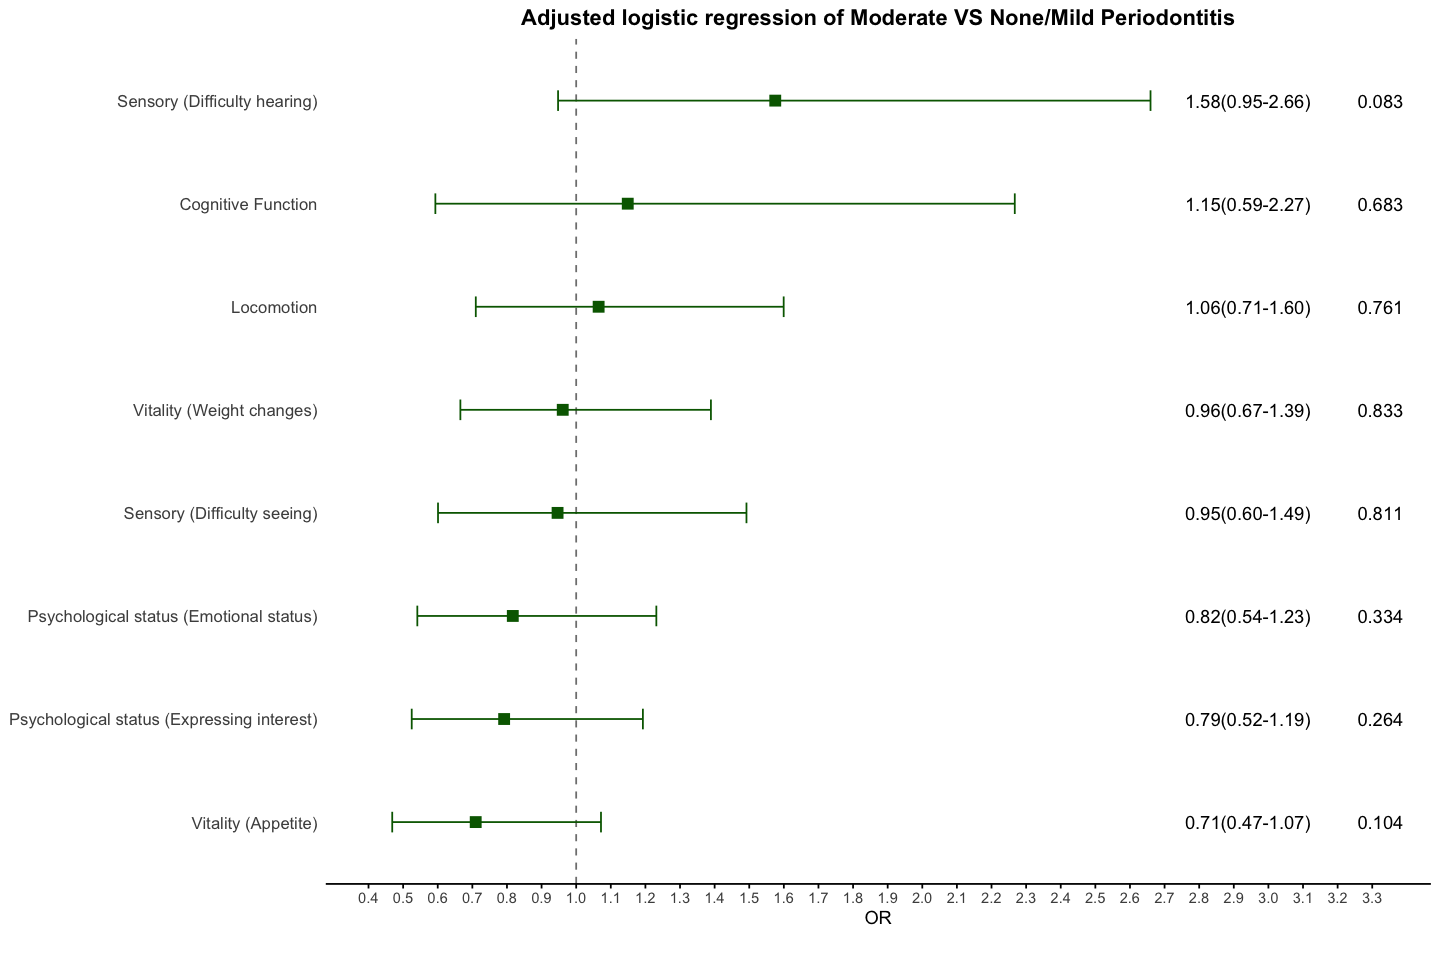

In [144]:
# Forest Plot

predictor_names <- c(
  "PFQ061I_bin" = "Locomotion",
  "DLQ040" = "Cognitive Function",
  "WHQ060" = "Vitality (Weight changes)",
  "DPQ050_bin" = "Vitality (Appetite)",
  "DPQ020_bin" = "Psychological status (Emotional status)",
  "DPQ010_bin" = "Psychological status (Expressing interest)",
  "DLQ010" = "Sensory (Difficulty hearing)",
  "DLQ020" = "Sensory (Difficulty seeing)"
)

moderate_overall_data <- prepare_forest_data_from_list(results_list, "moderate", "overall", predictor_names)

moderate_plot <- create_odds_ratio_forest_plot(moderate_overall_data, 
                                             "Adjusted logistic regression of Moderate VS None/Mild Periodontitis")

options(repr.plot.width = 12, repr.plot.height = 8)
print(moderate_plot)

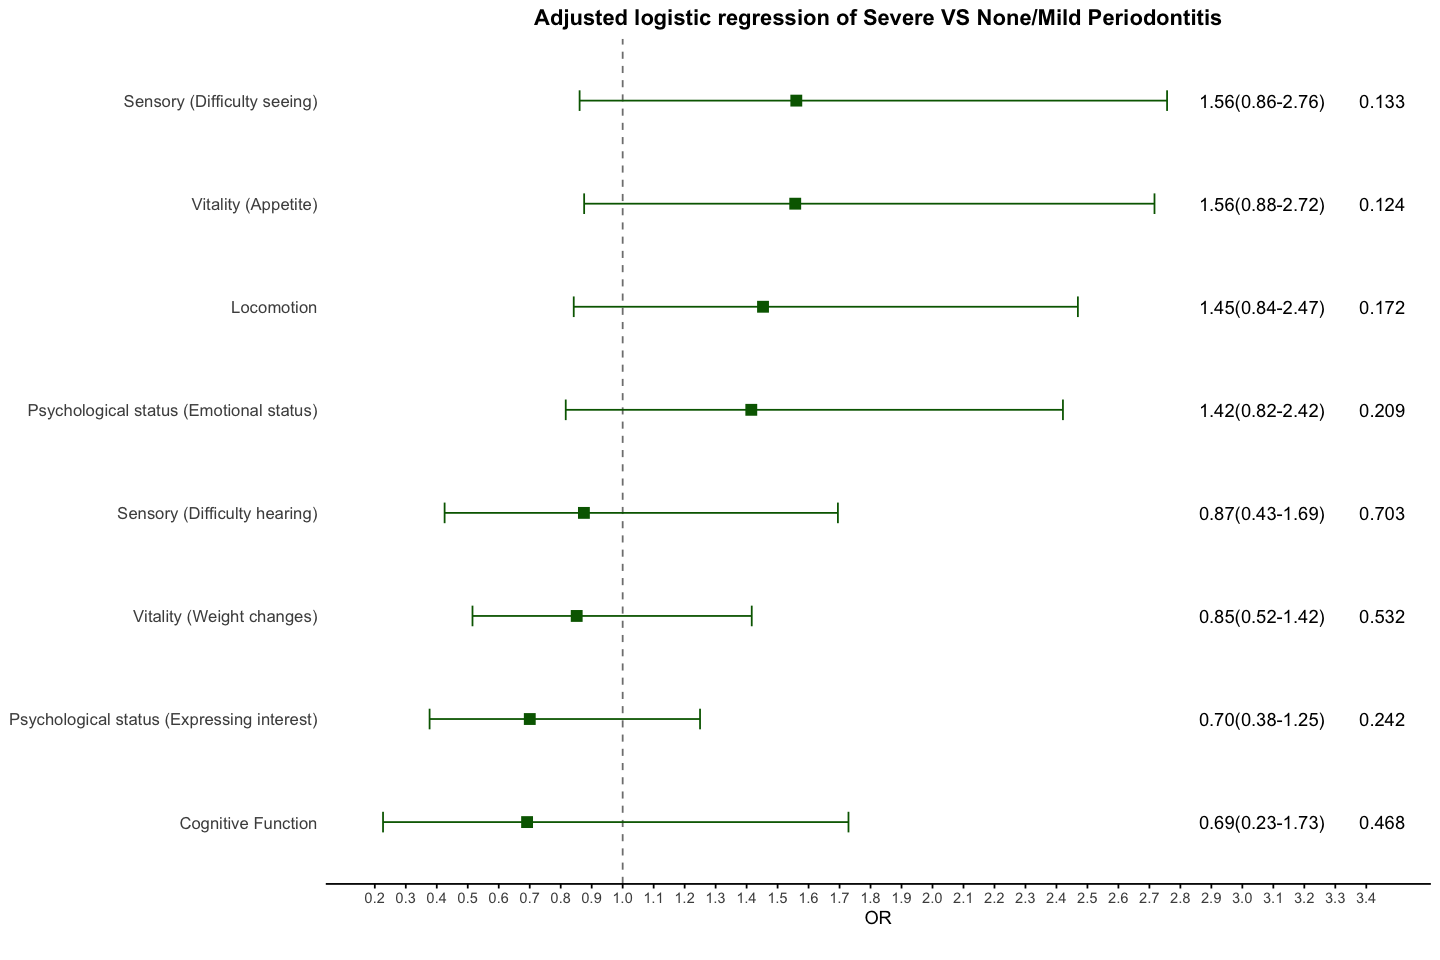

In [145]:
# Severe Periodontitis Visualization

severe_overall_data <- prepare_forest_data_from_list(results_list, "severe", "overall", predictor_names)
severe_plot <- create_odds_ratio_forest_plot(severe_overall_data, 
                                          "Adjusted logistic regression of Severe VS None/Mild Periodontitis")
severe_plot

In [100]:
# Saving Table in the csv format

csv_table <- final_table
colnames(csv_table) <- c(
    "Predictor",
    "Moderate periodontitis - OR (95% CI) - Overall",
    "Moderate periodontitis - OR (95% CI) - Males",
    "Moderate periodontitis - OR (95% CI) - Females",
    "Severe periodontitis - OR (95% CI) - Overall",
    "Severe periodontitis - OR (95% CI) - Males",
    "Severe periodontitis - OR (95% CI) - Females"
)

write.csv(csv_table, "/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/results/NHANES_13_14/adjusted_logistic_regression_results.csv", row.names = FALSE)

### Data Exploration and Visualization

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales)
library(forcats)
library(corrplot)
library(GGally)
library(viridis)
library(patchwork)

In [46]:
df <- read.csv("/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics/data/NHANES/recoded_df_09_14.csv", 
              stringsAsFactors = TRUE)

head(df)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC2,INDFMPIR,SMQ020,ALQ101,MCQ160B,MCQ160C,...,DPQ020,DPQ050,WHQ060,periodontitis,mean_ppd,mean_cal,PFQ061I_bin,DPQ050_bin,DPQ020_bin,DPQ010_bin
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,51633,1,80,3,4,1.27,1,1,2,2,...,0,0,1,Moderate,2.26,1.26,0,0,0,0
2,51654,1,66,3,4,2.20,1,1,2,2,...,0,0,0,Moderate,1.95,1.72,0,0,0,0
3,51680,2,60,4,4,2.59,1,1,2,2,...,1,1,1,Severe,1.81,1.48,0,1,1,0
4,51687,1,78,3,5,5.00,1,1,2,2,...,0,0,0,None/Mild,1.29,1.27,0,0,0,0
5,51736,2,60,1,3,0.68,1,1,2,2,...,1,0,1,Moderate,2.49,1.99,0,0,1,0
6,51861,1,80,3,3,4.94,2,1,2,1,...,0,0,1,Moderate,1.70,1.33,1,0,0,0


In [103]:
# Conversion of the variable periodontitis into factor with specific order

df$periodontitis <- factor(df$periodontitis, 
                          levels = c("None/Mild", "Moderate", "Severe"),
                          ordered = TRUE)

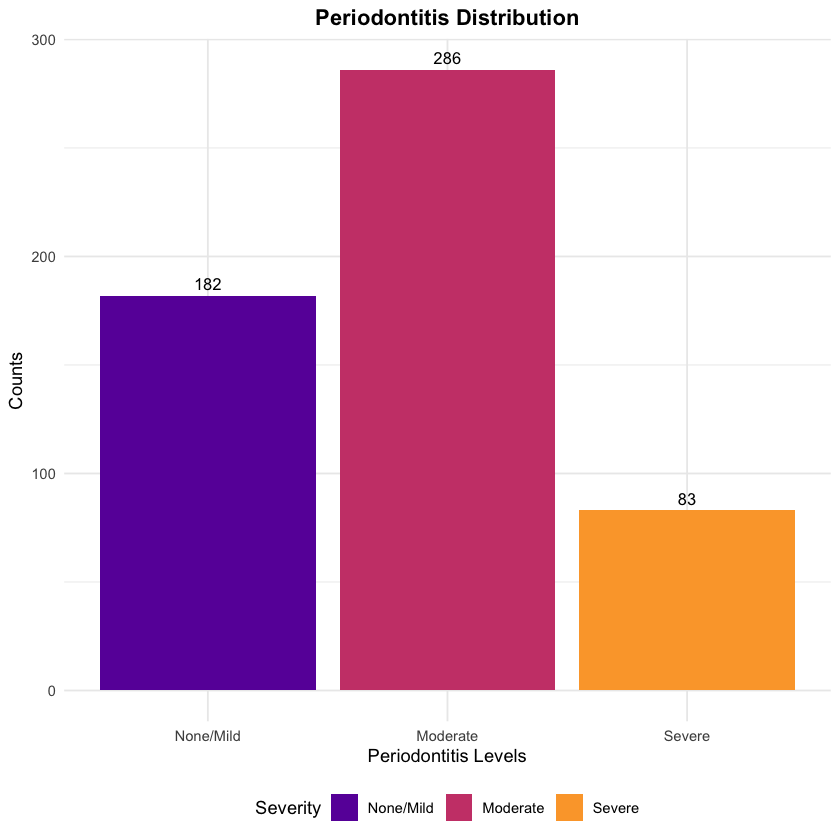

In [ ]:
# Bar graph for periodontitis distribution

ggplot(df, aes(x = periodontitis, fill = periodontitis)) +
  geom_bar() +
  geom_text(stat = "count", aes(label = after_stat(count)), 
            vjust = -0.5, size = 3.5) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis Distribution",
       x = "Periodontitis Levels",
       y = "Counts",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 0, hjust = 0.5))

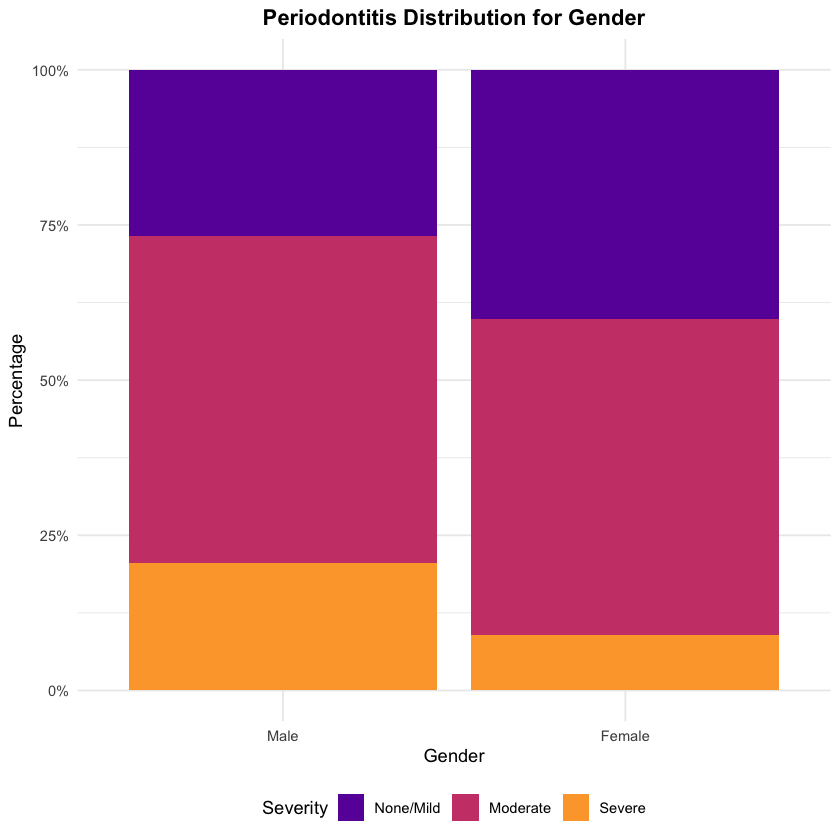

In [104]:
# Gender Encoding
df$gender <- factor(df$RIAGENDR, 
                   levels = c(1, 2), 
                   labels = c("Male", "Female"))

# Stacked bar graph for periodontitis by gender
ggplot(df, aes(x = gender, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis Distribution for Gender",
       x = "Gender",
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

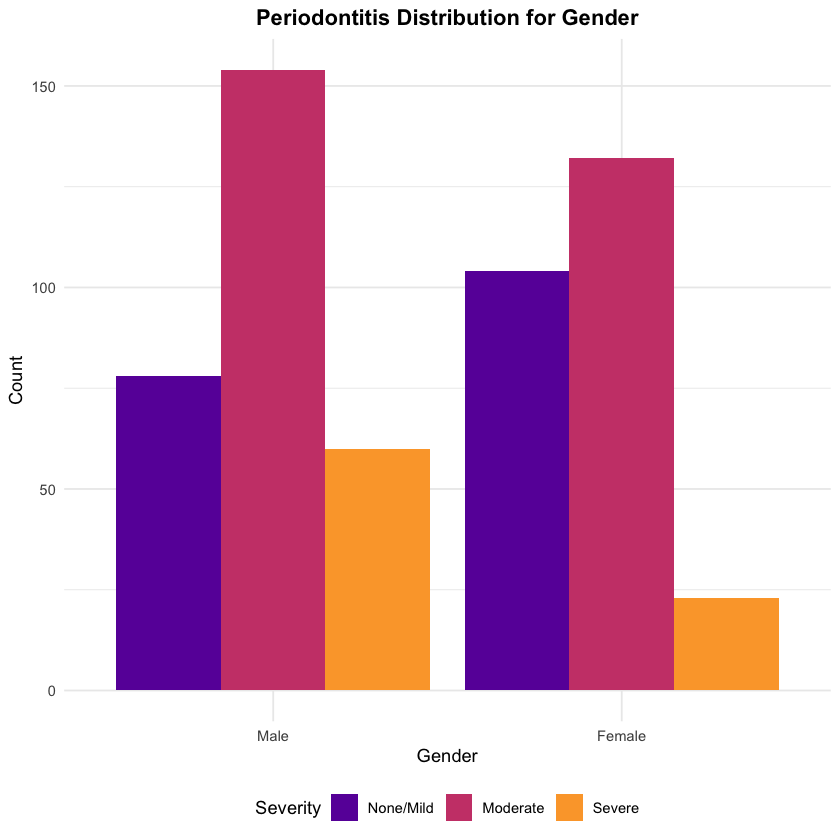

In [105]:
# Side-by-side bar graph for periodontitis by gender

ggplot(df, aes(x = gender, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis Distribution for Gender",
       x = "Gender", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

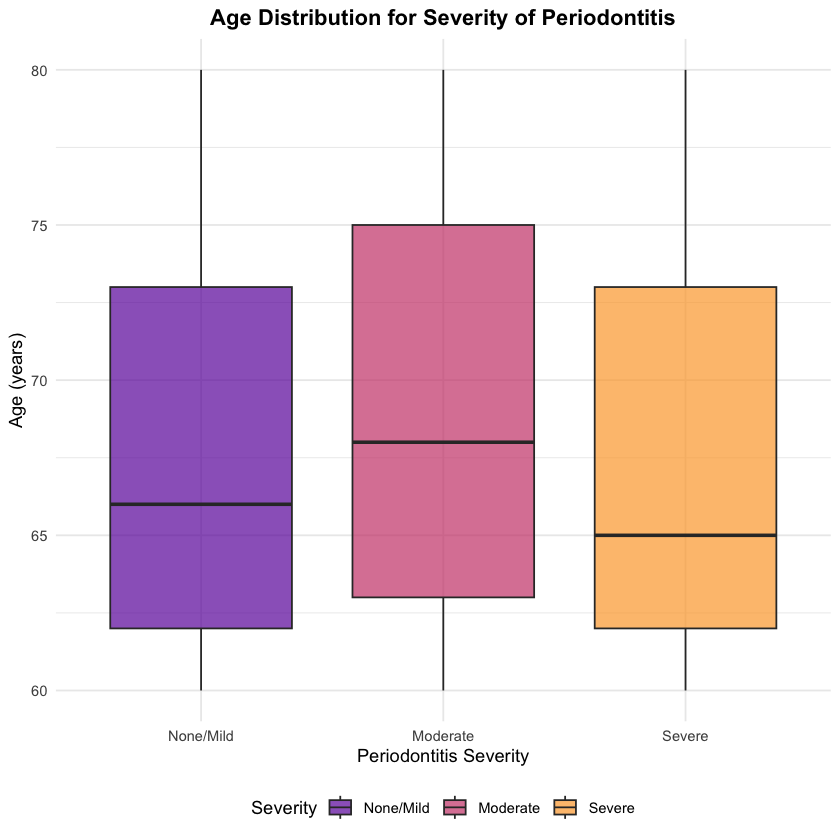

In [53]:
# Age Distribution for Severity of Periodontitis

ggplot(df, aes(x = periodontitis, y = RIDAGEYR, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Age Distribution for Severity of Periodontitis",
       x = "Periodontitis Severity", 
       y = "Age (years)",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

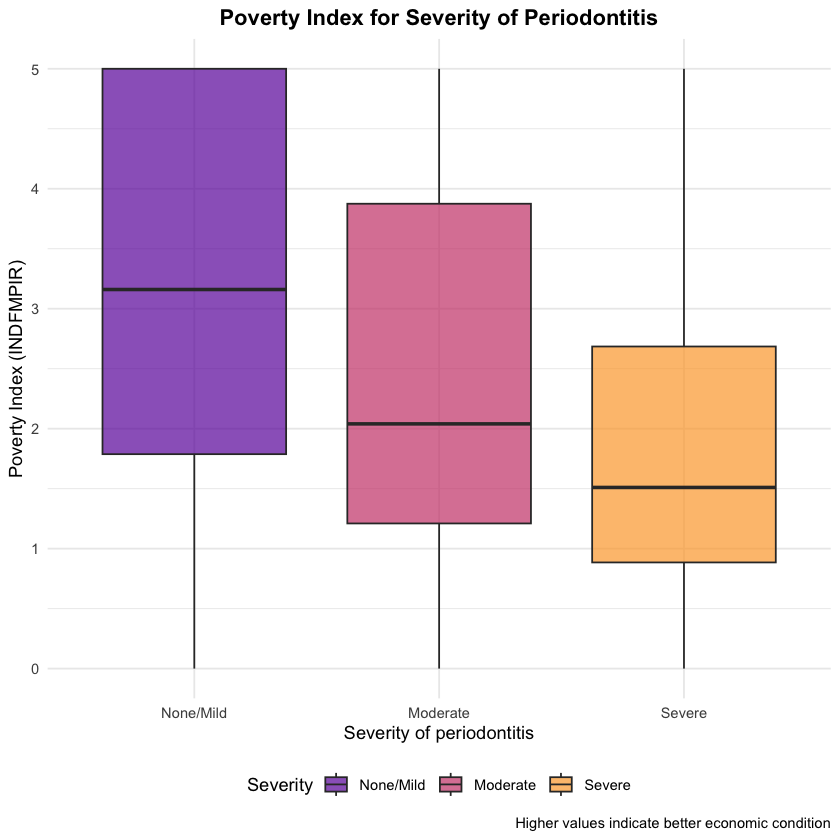

In [64]:
# Socio-Economic Condition (INDFMPIR) and Periodontitis

ggplot(df, aes(x = periodontitis, y = INDFMPIR, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Poverty Index for Severity of Periodontitis",
       x = "Severity of periodontitis", 
       y = "Poverty Index (INDFMPIR)",
       caption = "Higher values indicate better economic condition",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

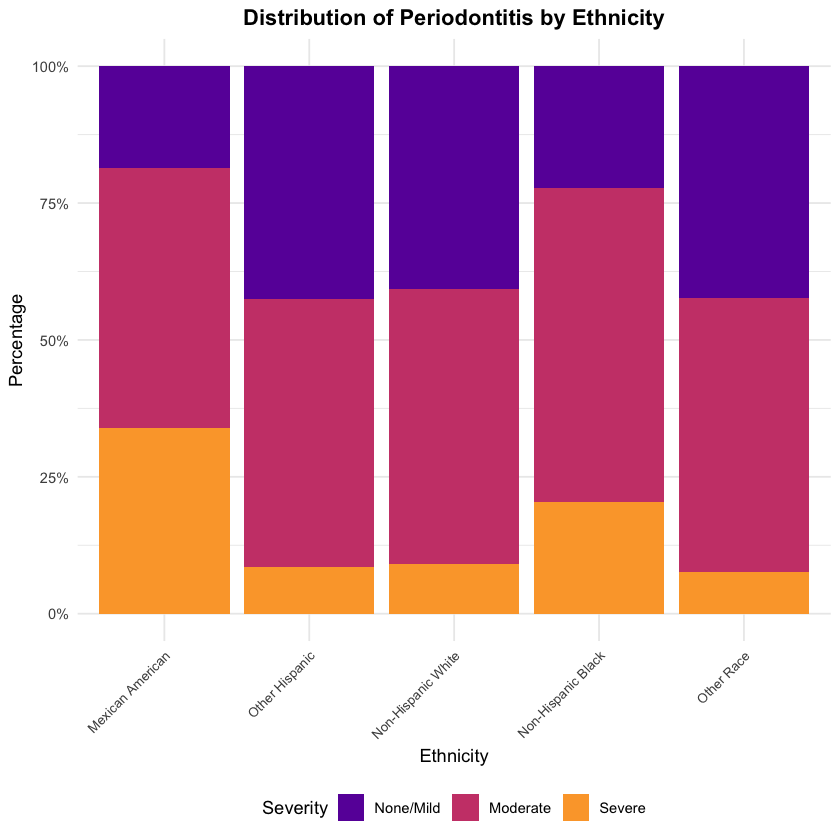

In [111]:
# Ethnicity and Periodontitis
# Encoding RIDRETH1 (ethnicity)

df$ethnicity <- factor(df$RIDRETH1, 
                      levels = c(1, 2, 3, 4, 5), 
                      labels = c("Mexican American",
                                 "Other Hispanic",
                                 "Non-Hispanic White",
                                 "Non-Hispanic Black",
                                 "Other Race"))

ggplot(df, aes(x = ethnicity, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Distribution of Periodontitis by Ethnicity",
       x = "Ethnicity", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

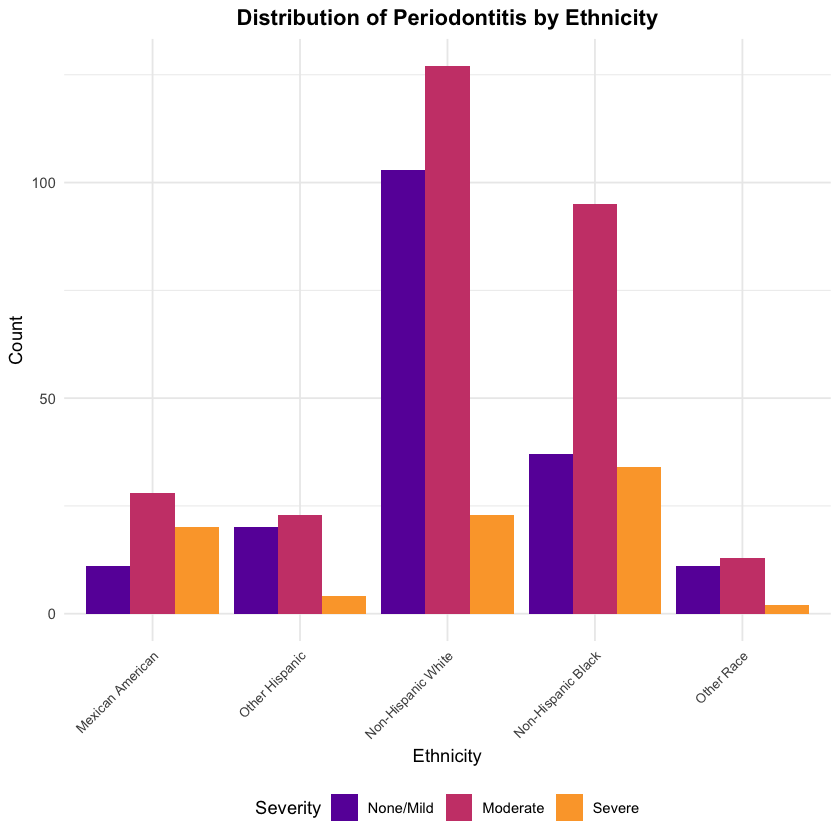

In [112]:
# Bar graph side-by-side for ethnicity and periodontitis

ggplot(df, aes(x = ethnicity, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Distribution of Periodontitis by Ethnicity",
       x = "Ethnicity", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

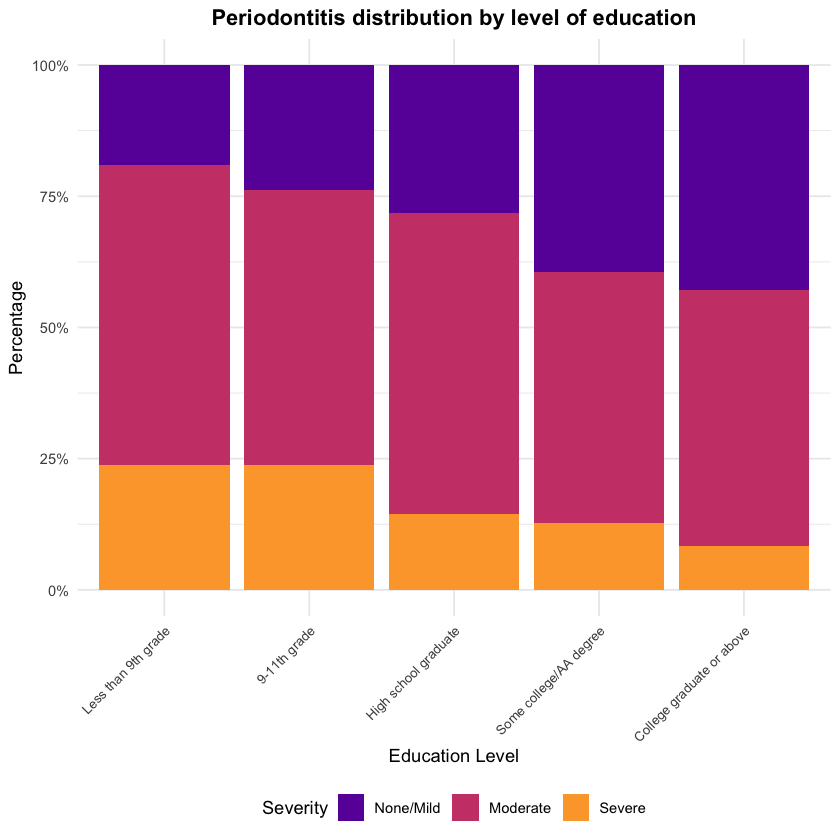

In [108]:
# Education Level and Periodontitis
# Encoding DMDEDUC2 (education)
df$education <- factor(df$DMDEDUC2, 
                      levels = c(1, 2, 3, 4, 5), 
                      labels = c("Less than 9th grade",
                                 "9-11th grade",
                                 "High school graduate",
                                 "Some college/AA degree",
                                 "College graduate or above"))

ggplot(df, aes(x = education, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis distribution by level of education",
       x = "Education Level", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

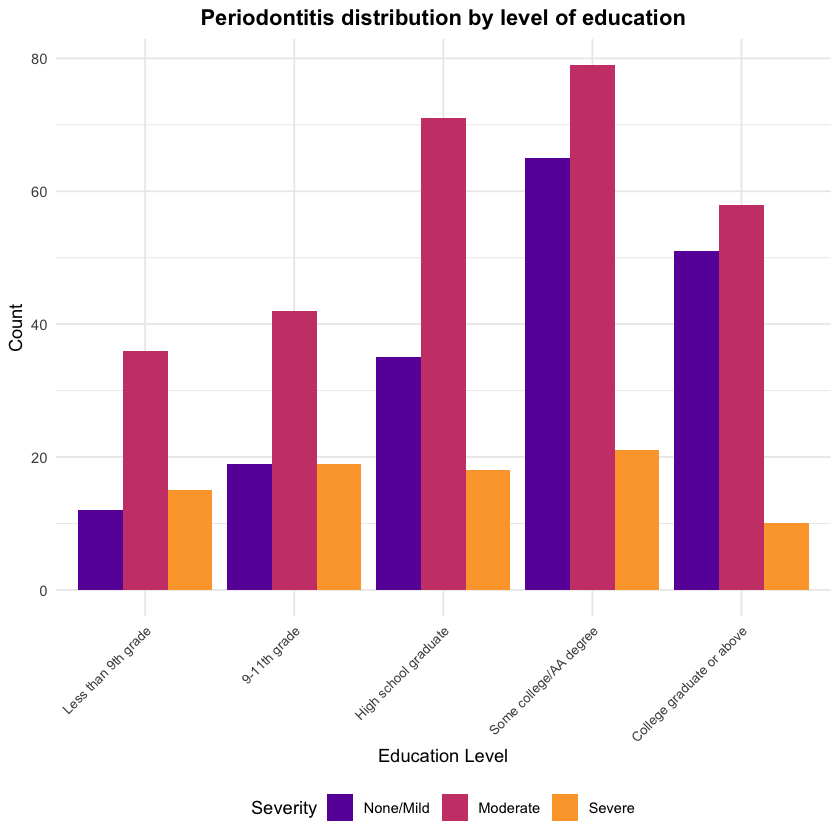

In [109]:
# Side-by-side bar graph for education and periodontitis

ggplot(df, aes(x = education, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis distribution by level of education",
       x = "Education Level", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8))

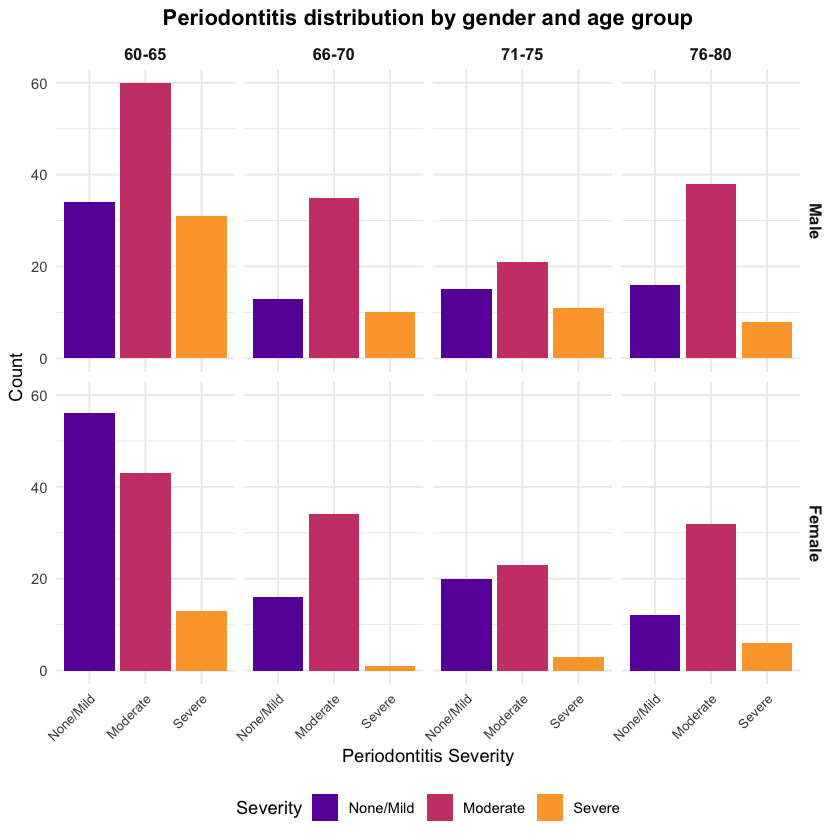

In [68]:
# FACET GRID FOR PERIODONTITIS BY GENDER AND AGE
# Creation of age groups
df$age_group <- cut(df$RIDAGEYR, 
                   breaks = c(59, 65, 70, 75, 81),
                   labels = c("60-65", "66-70", "71-75", "76-80"),
                   include.lowest = TRUE)

ggplot(df, aes(x = periodontitis, fill = periodontitis)) +
  geom_bar() +
  facet_grid(gender ~ age_group) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Periodontitis distribution by gender and age group",
       x = "Periodontitis Severity", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        strip.text = element_text(size = 10, face = "bold"))

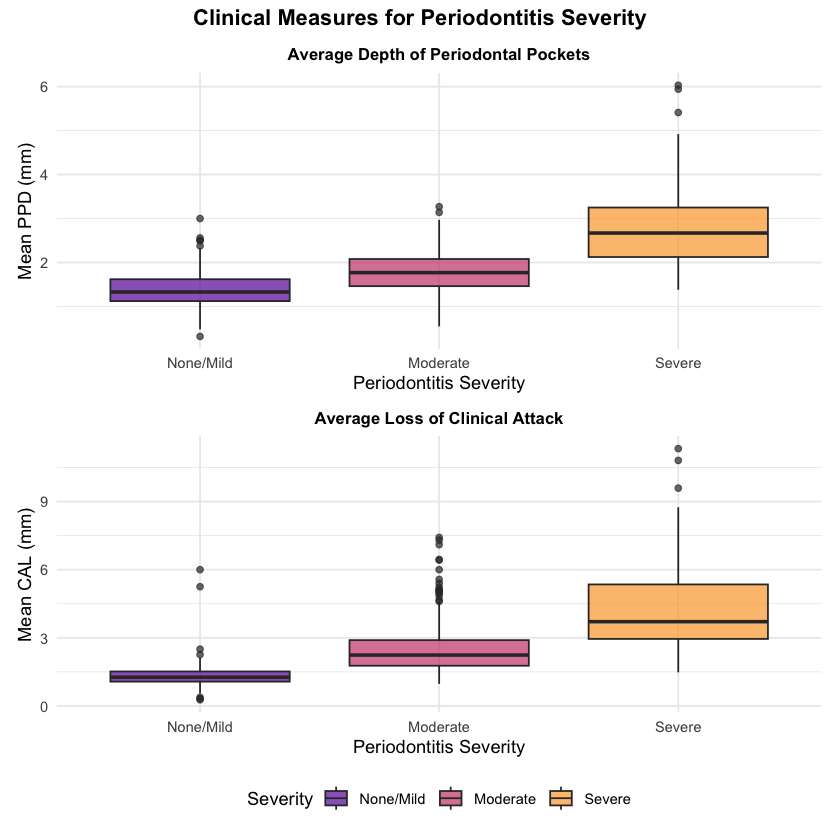

In [ ]:
# Boxplot for mean_ppd
ppd_plot <- ggplot(df, aes(x = periodontitis, y = mean_ppd, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Average Depth of Periodontal Pockets",
       x = "Periodontitis Severity",
       y = "Mean PPD (mm)",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "none",
        plot.title = element_text(hjust = 0.5, face = "bold", size = 10))

# Boxplot per mean_cal
cal_plot <- ggplot(df, aes(x = periodontitis, y = mean_cal, fill = periodontitis)) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Average Loss of Clinical Attack",
       x = "Periodontitis Severity",
       y = "Mean CAL (mm)",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "none",
        plot.title = element_text(hjust = 0.5, face = "bold", size = 10))

# Combine two plots
ppd_plot / cal_plot +
  plot_annotation(
    title = "Clinical Measures for Periodontitis Severity",
    theme = theme(plot.title = element_text(hjust = 0.5, face = "bold"))
  ) +
  plot_layout(guides = "collect") & 
  theme(legend.position = "bottom")

`geom_smooth()` using formula = 'y ~ x'


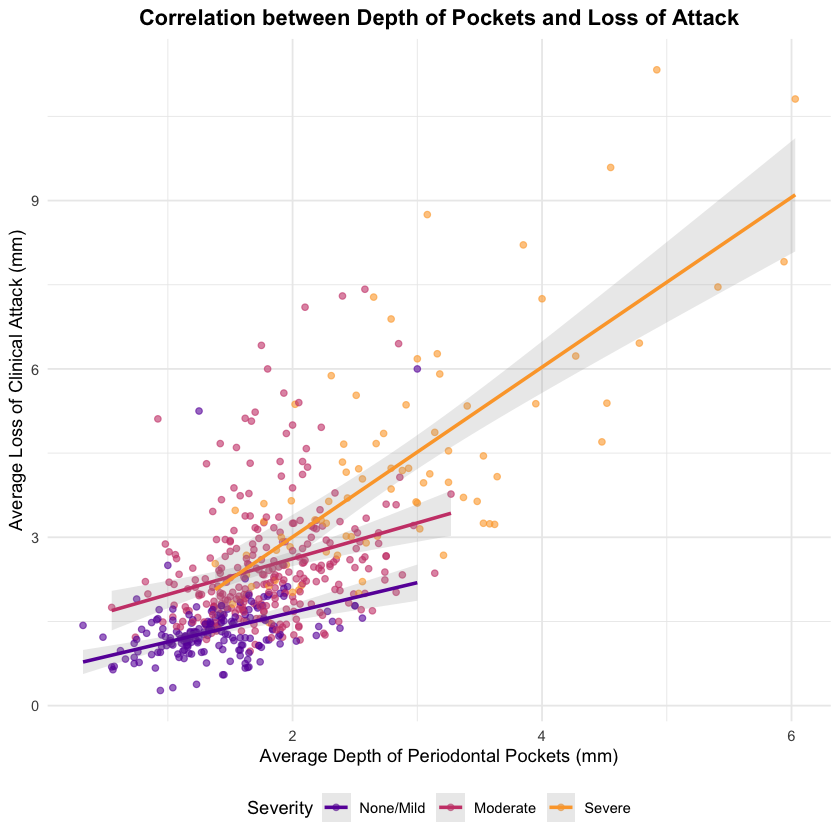

In [56]:
# Correlation between clinical measures: scatterplot with regression line

ggplot(df, aes(x = mean_ppd, y = mean_cal, color = periodontitis)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", se = TRUE, alpha = 0.2) +
  scale_color_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Correlation between Depth of Pockets and Loss of Attack",
       x = "Average Depth of Periodontal Pockets (mm)",
       y = "Average Loss of Clinical Attack (mm)",
       color = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

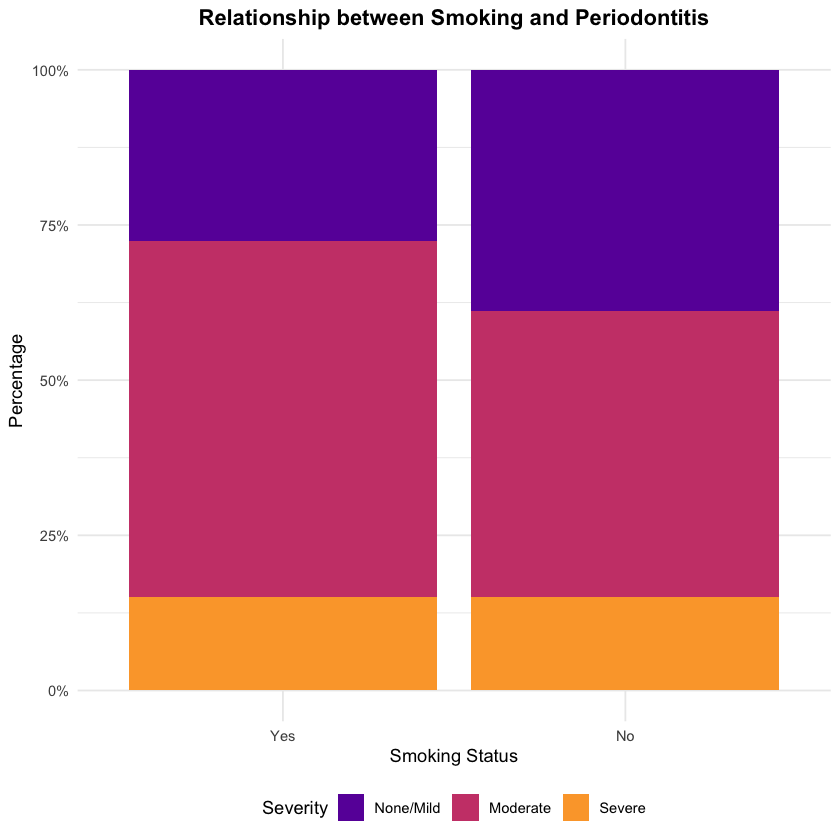

In [106]:
# Encoding SMQ020
df$smoking_status <- factor(df$SMQ020, 
                           levels = c(1, 2), 
                           labels = c("Yes", "No"))

mosaic_data <- table(df$smoking_status, df$periodontitis)

mosaic_df <- as.data.frame(mosaic_data)
names(mosaic_df) <- c("Smoking", "Periodontitis", "Count")

ggplot(mosaic_df, aes(x = Smoking, y = Count, fill = Periodontitis)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Smoking and Periodontitis",
       x = "Smoking Status",
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

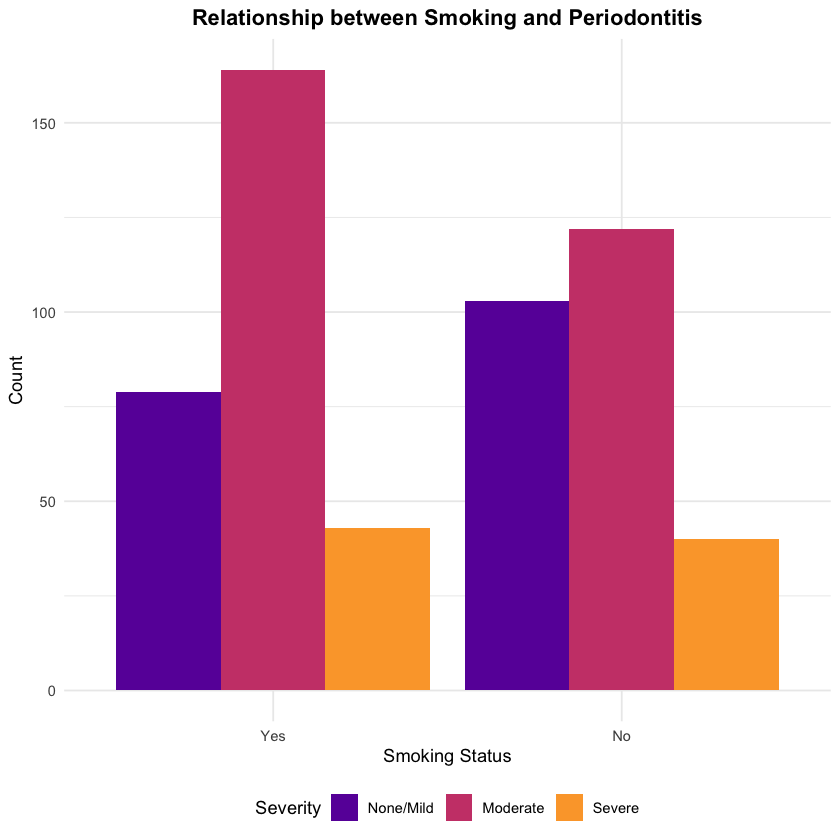

In [107]:
# Side-by-side bar graph for smoke and periodontitis

ggplot(df, aes(x = smoking_status, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Smoking and Periodontitis",
       x = "Smoking Status", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

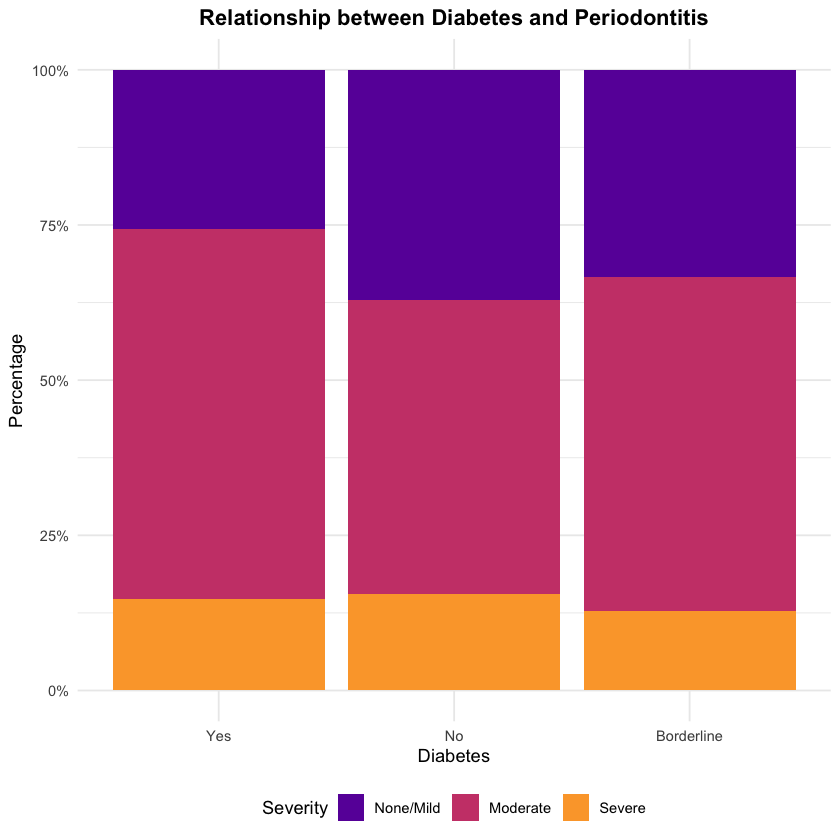

In [113]:
# Encoding DIQ010 (Diabetes)
df$diabetes <- factor(df$DIQ010, 
                     levels = c(1, 2, 3), 
                     labels = c("Yes", "No", "Borderline"))

# Contingency table
diabetes_perio <- table(df$diabetes, df$periodontitis)
diabetes_perio_df <- as.data.frame(diabetes_perio)
names(diabetes_perio_df) <- c("Diabetes", "Periodontitis", "Count")

ggplot(diabetes_perio_df, aes(x = Diabetes, y = Count, fill = Periodontitis)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Diabetes and Periodontitis",
       x = "Diabetes", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

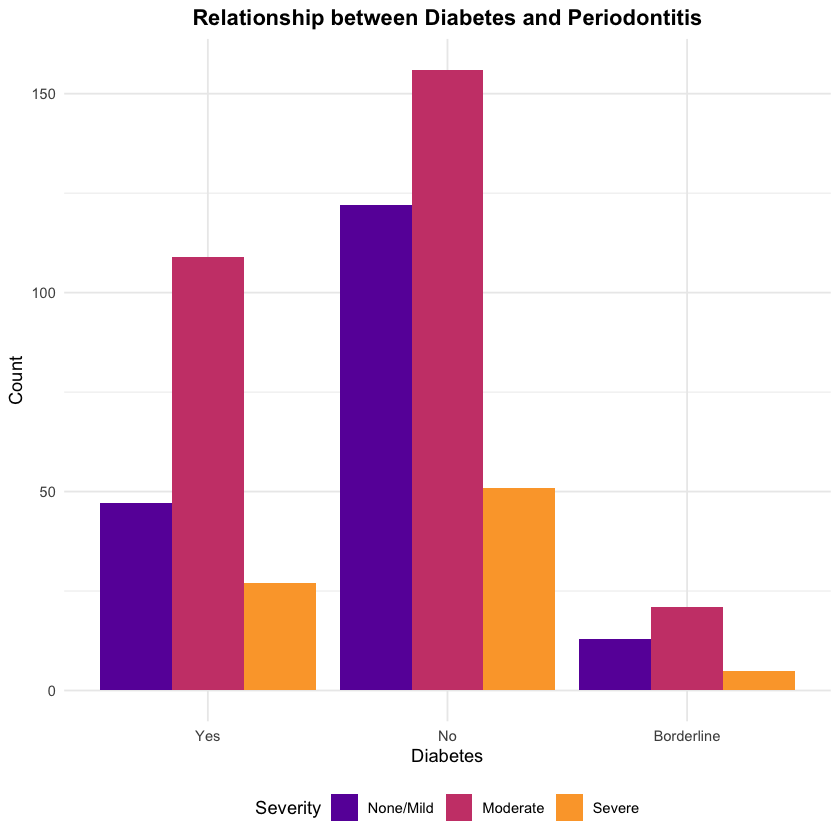

In [114]:
# Side-by-side bar graph for diabetes and periodontitis

ggplot(df, aes(x = diabetes, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between Diabetes and Periodontitis",
       x = "Diabetes", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

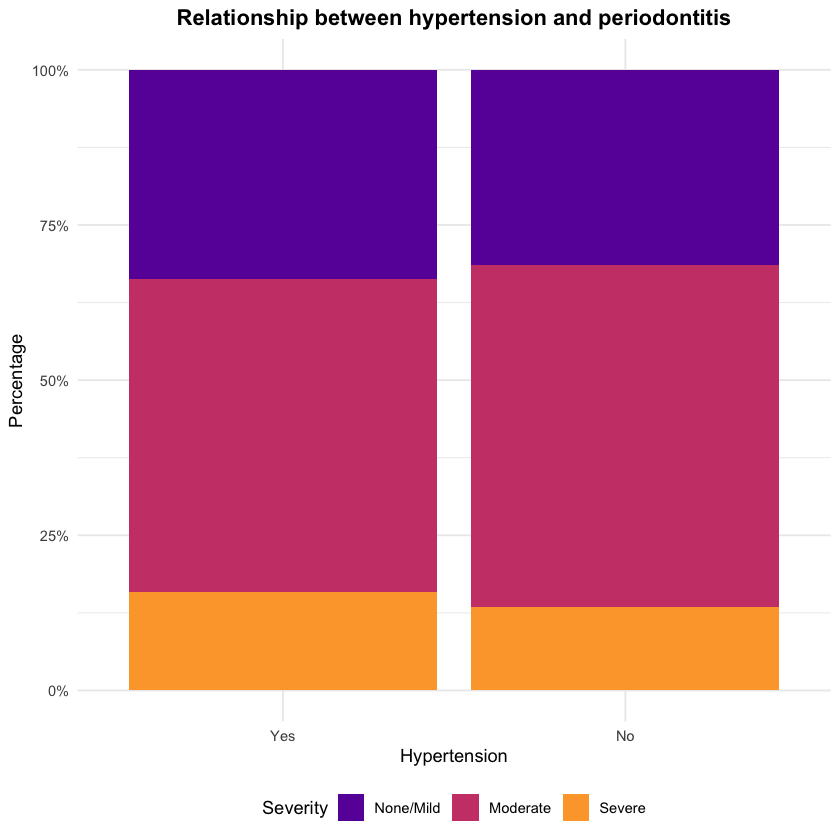

In [115]:
# Encoding BPQ020 (hypertension)
df$hypertension <- factor(df$BPQ020, 
                         levels = c(1, 2), 
                         labels = c("Yes", "No"))

ggplot(df, aes(x = hypertension, fill = periodontitis)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between hypertension and periodontitis",
       x = "Hypertension", 
       y = "Percentage",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))

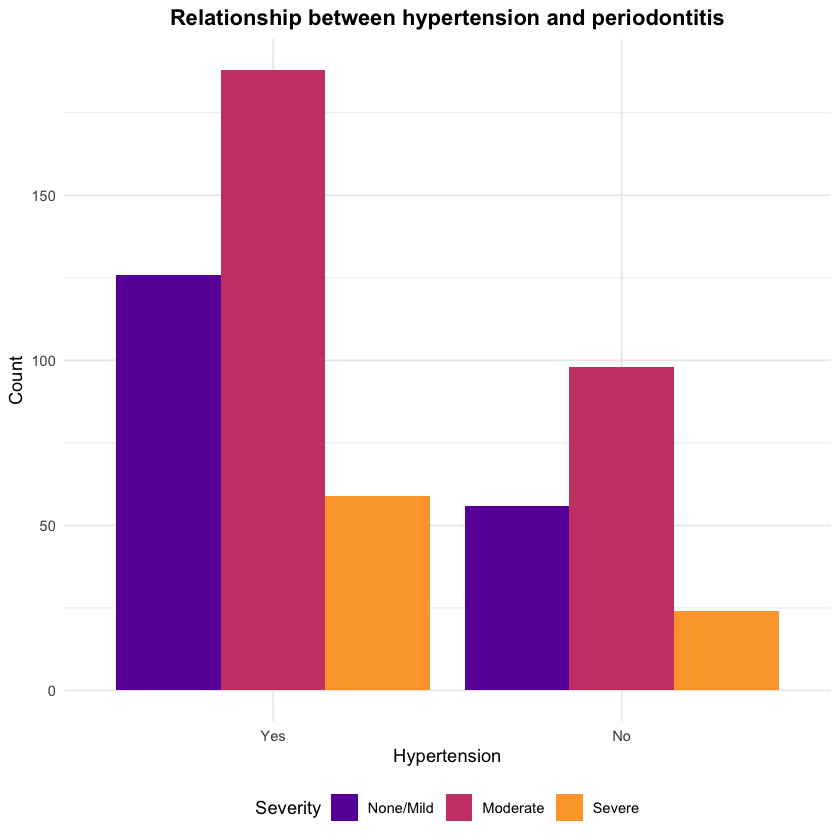

In [116]:
# Side-by-side bar chart for hypertension and periodontitis

ggplot(df, aes(x = hypertension, fill = periodontitis)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Relationship between hypertension and periodontitis",
       x = "Hypertension", 
       y = "Count",
       fill = "Severity") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"))